<a href="https://colab.research.google.com/github/aday651/comp-journal/blob/master/covid-data-quality/wrangling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Important library for many geopython libraries
!apt install gdal-bin python-gdal python3-gdal 
# Install rtree - Geopandas requirment
!apt install python3-rtree 
# Install Geopandas
!pip install git+git://github.com/geopandas/geopandas.git
# Install descartes - Geopandas requirment
!pip install descartes 
# Install Folium for Geographic data visualization
!pip install folium
# Install plotlyExpress
!pip install plotly_express
# Install sodapy
!pip install sodapy

## Obtaining the data

In [2]:
import pandas as pd
import geopandas as gpd
from sodapy import Socrata

federal_client = Socrata(
    "healthdata.gov",
    'PmTWj6hExEV3muUjErx8lqo9h',
    username = '67mk7nwz4pplnp23qzuogdbrb',
    password = '4j8ensof75ev2hs3ew4njx89hx1v9gvhzedtsssu0rptc9iu9a'
)

hospital_query = """
SELECT
    hospital_pk,
    hospital_name,
    collection_week,
    state,
    fips_code,
    geocoded_hospital_address,
    total_personnel_covid_vaccinated_doses_none_7_day AS no_dose_personnel,
    total_personnel_covid_vaccinated_doses_one_7_day AS one_dose_personnel,
    total_personnel_covid_vaccinated_doses_all_7_day AS two_dose_personnel
WHERE
    collection_week >= '2021-04-01T00:00:00.000'
LIMIT
    300000
"""

survey_results = federal_client.get(
    "anag-cw7u", 
    content_type = 'json',
    query = hospital_query
)

In [3]:
survey_results_df = pd.DataFrame.from_records(survey_results)
survey_results_df.head()

,hospital_pk,hospital_name,collection_week,state,fips_code,no_dose_personnel,one_dose_personnel,two_dose_personnel,geocoded_hospital_address
0,370220,ONECORE HEALTH,2021-04-02T00:00:00.000,OK,40109,56,5,33,NaN
1,201301,CHARLES A DEAN MEMORIAL HOSPITAL,2021-04-02T00:00:00.000,ME,23021,0,0,0,NaN
2,450351,TEXAS HEALTH HARRIS METHODIST HOSPITAL STEPHEN...,2021-04-02T00:00:00.000,TX,48143,NaN,NaN,NaN,"{'type': 'Point', 'coordinates': [-98.204848, ..."
3,102017,SELECT SPECIALTY HOSPITAL - PANAMA CITY,2021-04-02T00:00:00.000,FL,12005,0,0,0,"{'type': 'Point', 'coordinates': [-85.647067, ..."
4,361328,DEFIANCE REGIONAL MEDICAL CENTER,2021-04-02T00:00:00.000,OH,39039,269,28,324,"{'type': 'Point', 'coordinates': [-84.373661, ..."


In [4]:
survey_results_df = survey_results_df.astype({
    'hospital_pk': 'string',
    'hospital_name': 'string',
    'collection_week': 'datetime64',
    'state': 'string',
    'fips_code': 'string',
    'geocoded_hospital_address': 'string',
    'no_dose_personnel': 'float_',
    'one_dose_personnel': 'float_',
    'two_dose_personnel': 'float_'
})

survey_results_df.head()

,hospital_pk,hospital_name,collection_week,state,fips_code,no_dose_personnel,one_dose_personnel,two_dose_personnel,geocoded_hospital_address
0,370220,ONECORE HEALTH,2021-04-02,OK,40109,56.0,5.0,33.0,<NA>
1,201301,CHARLES A DEAN MEMORIAL HOSPITAL,2021-04-02,ME,23021,0.0,0.0,0.0,<NA>
2,450351,TEXAS HEALTH HARRIS METHODIST HOSPITAL STEPHEN...,2021-04-02,TX,48143,NaN,NaN,NaN,"{'type': 'Point', 'coordinates': [-98.204848, ..."
3,102017,SELECT SPECIALTY HOSPITAL - PANAMA CITY,2021-04-02,FL,12005,0.0,0.0,0.0,"{'type': 'Point', 'coordinates': [-85.647067, ..."
4,361328,DEFIANCE REGIONAL MEDICAL CENTER,2021-04-02,OH,39039,269.0,28.0,324.0,"{'type': 'Point', 'coordinates': [-84.373661, ..."


In [5]:
from shapely.geometry import shape
import ast

geoms = [shape(ast.literal_eval(geojson)) if not pd.isna(geojson) else None for geojson in survey_results_df.geocoded_hospital_address]

In [6]:
survey_results_df = gpd.GeoDataFrame(
    survey_results_df.drop('geocoded_hospital_address', 1), geometry = geoms 
)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  


In [7]:
survey_results_df

,hospital_pk,hospital_name,collection_week,state,fips_code,no_dose_personnel,one_dose_personnel,two_dose_personnel,geometry
0,370220,ONECORE HEALTH,2021-04-02,OK,40109,56.0,5.0,33.0,None
1,201301,CHARLES A DEAN MEMORIAL HOSPITAL,2021-04-02,ME,23021,0.0,0.0,0.0,None
2,450351,TEXAS HEALTH HARRIS METHODIST HOSPITAL STEPHEN...,2021-04-02,TX,48143,NaN,NaN,NaN,POINT (-98.20485 32.22313)
3,102017,SELECT SPECIALTY HOSPITAL - PANAMA CITY,2021-04-02,FL,12005,0.0,0.0,0.0,POINT (-85.64707 30.15966)
4,361328,DEFIANCE REGIONAL MEDICAL CENTER,2021-04-02,OH,39039,269.0,28.0,324.0,POINT (-84.37366 41.29951)
...,...,...,...,...,...,...,...,...,...
215452,192028,RIVERBRIDGE SPECIALTY HOSPITAL,2022-01-21,LA,22029,65.0,120.0,118.0,POINT (-91.41918 31.56568)
215453,390062,CONEMAUGH NASON MEDICAL CENTER,2022-01-21,PA,42013,NaN,NaN,NaN,POINT (-78.38857 40.33797)
215454,500139,MULTICARE CAPITAL MEDICAL CENTER,2022-01-21,WA,53067,NaN,NaN,NaN,POINT (-122.95158 47.04168)
215455,100081,HEALTHMARK REGIONAL MEDICAL CENTER,2022-01-21,FL,12131,NaN,NaN,NaN,POINT (-86.11899 30.65889)


In [8]:
survey_results_df.collection_week.unique()

array(['2021-04-02T00:00:00.000000000', '2021-04-09T00:00:00.000000000',
       '2021-04-16T00:00:00.000000000', '2021-04-23T00:00:00.000000000',
       '2021-04-30T00:00:00.000000000', '2021-05-07T00:00:00.000000000',
       '2021-05-14T00:00:00.000000000', '2021-05-21T00:00:00.000000000',
       '2021-05-28T00:00:00.000000000', '2021-06-04T00:00:00.000000000',
       '2021-06-11T00:00:00.000000000', '2021-06-18T00:00:00.000000000',
       '2021-06-25T00:00:00.000000000', '2021-07-02T00:00:00.000000000',
       '2021-07-09T00:00:00.000000000', '2021-07-16T00:00:00.000000000',
       '2021-07-23T00:00:00.000000000', '2021-07-30T00:00:00.000000000',
       '2021-08-06T00:00:00.000000000', '2021-08-13T00:00:00.000000000',
       '2021-08-20T00:00:00.000000000', '2021-08-27T00:00:00.000000000',
       '2021-09-03T00:00:00.000000000', '2021-09-10T00:00:00.000000000',
       '2021-09-17T00:00:00.000000000', '2021-09-24T00:00:00.000000000',
       '2021-10-01T00:00:00.000000000', '2021-10-08

Dates we'll look at:
- April 9th 2021 (the day used in the original map)
- November 5th 2021 (the day after the [Biden administration](https://www.whitehouse.gov/briefing-room/statements-releases/2021/11/04/fact-sheet-biden-administration-announces-details-of-two-major-vaccination-policies/) announced
a requirement for healthcare workers to be vaccinated)
- January 14th 2022 (the most recent response, and 10 days after
the original date given by the for Biden administration for when
healthcare workers would need to be vaccinated by)

In [9]:
cdc_client = Socrata(
    "data.cdc.gov",
    'PmTWj6hExEV3muUjErx8lqo9h',
    username = '67mk7nwz4pplnp23qzuogdbrb',
    password = '4j8ensof75ev2hs3ew4njx89hx1v9gvhzedtsssu0rptc9iu9a'
)

covid_query = """
SELECT
    date,
    fips,
    recip_county,
    recip_state,
    Administered_Dose1_Recip_18PlusPop_Pct AS one_dose_pop,
    Series_Complete_18PlusPop_Pct AS two_dose_pop,
    census2019 AS county_pop_size
WHERE
    date IN (
        '2021-04-09T00:00:00.000',
        '2021-11-05T00:00:00.000',
        '2022-01-14T00:00:00.000'
    )
LIMIT
    10000
"""

county_covid = cdc_client.get("8xkx-amqh", query = covid_query)
county_covid_df = pd.DataFrame.from_records(county_covid)

county_covid_df = county_covid_df.astype({
    'date': 'datetime64',
    'fips': 'string',
    'recip_county': 'string',
    'recip_state': 'string',
    'one_dose_pop': 'float_',
    'two_dose_pop': 'float',
    'county_pop_size': 'float_'
})

county_covid_df

,date,fips,recip_county,recip_state,one_dose_pop,two_dose_pop,county_pop_size
0,2021-04-09,51740,Portsmouth city,VA,59.0,36.8,94398.0
1,2021-04-09,29227,Worth County,MO,35.3,29.0,2013.0
2,2021-04-09,38079,Rolette County,ND,62.5,58.4,14176.0
3,2021-04-09,13273,Terrell County,GA,8.5,5.5,8531.0
4,2021-04-09,56037,Sweetwater County,WY,34.0,26.5,42343.0
...,...,...,...,...,...,...,...
9843,2022-01-14,38049,McHenry County,ND,56.4,50.9,5745.0
9844,2022-01-14,48065,Carson County,TX,51.8,45.0,5926.0
9845,2022-01-14,48271,Kinney County,TX,65.8,56.4,3667.0
9846,2022-01-14,46109,Roberts County,SD,95.0,85.0,10394.0


In [10]:
!wget -q https://www2.census.gov/geo/tiger/GENZ2018/shp/cb_2018_us_county_500k.zip
!unzip -q cb_2018_us_county_500k

--2022-02-03 02:07:15--  https://www2.census.gov/geo/tiger/GENZ2018/shp/cb_2018_us_county_500k.zip
Resolving www2.census.gov (www2.census.gov)... 104.91.100.6, 2600:1400:d:29b::208c, 2600:1400:d:2bf::208c
Connecting to www2.census.gov (www2.census.gov)|104.91.100.6|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘cb_2018_us_county_500k.zip.2’

cb_2018_us_county_5     [     <=>            ]  11.00M  12.9MB/s    in 0.9s    

2022-02-03 02:07:17 (12.9 MB/s) - ‘cb_2018_us_county_500k.zip.2’ saved [11530479]

Archive:  cb_2018_us_county_500k.zip
replace cb_2018_us_county_500k.shp.ea.iso.xml? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace cb_2018_us_county_500k.shp.iso.xml? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace cb_2018_us_county_500k.shp? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace cb_2018_us_county_500k.shx? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace cb_2018_us_county_500k.dbf? [y]es, [n]o, [A]ll, [N]one,

In [11]:
county_shapes = gpd.read_file('/content/cb_2018_us_county_500k.shp') 
county_shapes = county_shapes[['GEOID', 'geometry']]
county_covid_df = county_shapes.merge(
    county_covid_df, 
    left_on = 'GEOID', right_on = 'fips',
    how = 'right'
  )

In [12]:
county_covid_df

,GEOID,geometry,date,fips,recip_county,recip_state,one_dose_pop,two_dose_pop,county_pop_size
0,51740,"POLYGON ((-76.41935 36.86754, -76.41343 36.874...",2021-04-09,51740,Portsmouth city,VA,59.0,36.8,94398.0
1,29227,"POLYGON ((-94.63203 40.57119, -94.59400 40.570...",2021-04-09,29227,Worth County,MO,35.3,29.0,2013.0
2,38079,"POLYGON ((-100.18297 48.76240, -100.18297 48.7...",2021-04-09,38079,Rolette County,ND,62.5,58.4,14176.0
3,13273,"POLYGON ((-84.60282 31.78070, -84.60286 31.783...",2021-04-09,13273,Terrell County,GA,8.5,5.5,8531.0
4,56037,"POLYGON ((-110.05438 42.01103, -110.05436 42.0...",2021-04-09,56037,Sweetwater County,WY,34.0,26.5,42343.0
...,...,...,...,...,...,...,...,...,...
9843,38049,"POLYGON ((-101.05991 48.38598, -101.05988 48.4...",2022-01-14,38049,McHenry County,ND,56.4,50.9,5745.0
9844,48065,"POLYGON ((-101.62283 35.26153, -101.62280 35.2...",2022-01-14,48065,Carson County,TX,51.8,45.0,5926.0
9845,48271,"POLYGON ((-100.79705 29.23559, -100.79564 29.2...",2022-01-14,48271,Kinney County,TX,65.8,56.4,3667.0
9846,46109,"POLYGON ((-97.22829 45.93514, -97.14499 45.935...",2022-01-14,46109,Roberts County,SD,95.0,85.0,10394.0


In [13]:
survey_results_df.to_file('/content/survey_results.geojson', driver = 'GeoJSON')
county_covid_df.to_file('/content/county_covid.geojson', driver = 'GeoJSON')

## Exploring data quality issues

In [14]:
import numpy as np
import matplotlib.pyplot as plt  

In [15]:
survey_results_df = gpd.read_file('/content/survey_results.geojson')
county_covid_df = gpd.read_file('/content/county_covid.geojson')

In [16]:
# Replacing suppressed values with 0 for purposes of calculation
survey_results_df = survey_results_df.replace(-999999, 0)

In [17]:
obs_data = survey_results_df.dropna(
    subset = ['no_dose_personnel', 'one_dose_personnel', 'two_dose_personnel']
)

obs_data = pd.DataFrame(obs_data)

In [18]:
# Some of the hospitals appear to have A LOT of people
obs_data[obs_data['no_dose_personnel'] > 50000]

,hospital_pk,hospital_name,collection_week,state,fips_code,no_dose_personnel,one_dose_personnel,two_dose_personnel,geometry
99953,190008,TERREBONNE GENERAL HEALTH SYSTEM,2021-08-13,LA,22109,69912.0,1085.0,973.0,POINT (-90.71446 29.59854)
108452,190008,TERREBONNE GENERAL HEALTH SYSTEM,2021-08-27,LA,22109,69912.0,1085.0,973.0,POINT (-90.71446 29.59854)
114742,190008,TERREBONNE GENERAL HEALTH SYSTEM,2021-09-03,LA,22109,69912.0,1085.0,973.0,POINT (-90.71446 29.59854)
115628,190008,TERREBONNE GENERAL HEALTH SYSTEM,2021-09-10,LA,22109,69912.0,1085.0,973.0,POINT (-90.71446 29.59854)
177965,521323,MARSHFIELD MEDICAL CENTER - NEILLSVILLE,2021-12-03,WI,55019,520037.0,520037.0,520037.0,POINT (-90.61875 44.55450)


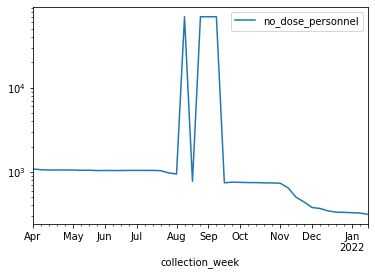

In [19]:
# Let's see what happens when we look at these hospitals
obs_data[obs_data['hospital_pk'] == '190008'].plot(
    x = 'collection_week',
    y = 'no_dose_personnel',
    logy = True
)

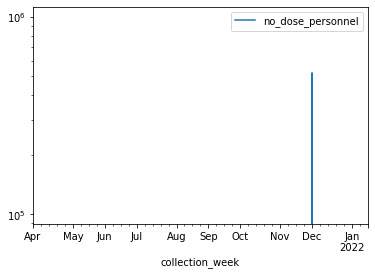

In [20]:
# Let's see what happens when we look at these hospitals
obs_data[obs_data['hospital_pk'] == '521323'].plot(
    x = 'collection_week',
    y = 'no_dose_personnel',
    logy = True
)

From this, we can see that some of the hospitals have issues with the variables
being coded over time (in that they are misrecorded substantially over time). If
we wanted to go into this in more depth, we could try and impute the correct values,
but for now, the easiest thing to try and do is to simple try and identify these outlier
values. Given how substantially large these deviations are, we can just use a standard
outlier detection procedure for this (i.e the 1.5 IQR rule).

In [21]:
# Note that there are issues with how the one_shot_personnel
# variable is coded
obs_data[obs_data['one_dose_personnel'] < obs_data['two_dose_personnel']]

,hospital_pk,hospital_name,collection_week,state,fips_code,no_dose_personnel,one_dose_personnel,two_dose_personnel,geometry
0,370220,ONECORE HEALTH,2021-04-02,OK,40109,56.0,5.0,33.0,None
4,361328,DEFIANCE REGIONAL MEDICAL CENTER,2021-04-02,OH,39039,269.0,28.0,324.0,POINT (-84.37366 41.29951)
9,360368,KETTERING MEDICAL CENTER,2021-04-02,OH,39109,195.0,5.0,93.0,POINT (-84.20923 40.04220)
10,260057,CAMERON REGIONAL MEDICAL CENTER,2021-04-02,MO,29049,304.0,0.0,146.0,POINT (-94.21831 39.73150)
13,243300,GILLETTE CHILDRENS SPECIALTY HOSPITAL,2021-04-02,MN,27123,287.0,0.0,1176.0,POINT (-93.09572 44.95652)
...,...,...,...,...,...,...,...,...,...
215442,371341,SHARE MEDICAL CENTER,2022-01-21,OK,40151,23.0,6.0,83.0,POINT (-98.67010 36.78703)
215444,471303,NORTHEASTERN VERMONT REGIONAL HOSPITAL,2022-01-21,VT,50005,30.0,7.0,654.0,POINT (-72.00966 44.44527)
215445,230230,EDWARD W SPARROW HOSPITAL,2022-01-21,MI,26065,976.0,113.0,4449.0,POINT (-84.53482 42.73361)
215446,010125,LAKELAND COMMUNITY HOSPITAL,2022-01-21,AL,01133,47.0,15.0,211.0,POINT (-87.58986 34.24172)


(10.0, 10000.0)

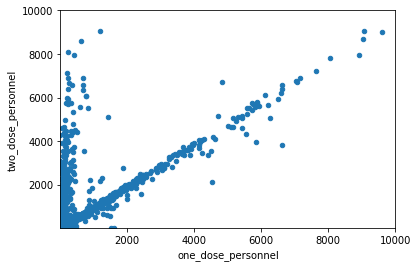

In [22]:
ax = obs_data[obs_data['collection_week'] == '2021-04-02'].plot.scatter(
    x = 'one_dose_personnel',
    y = 'two_dose_personnel'
)

ax.set_xlim(10, 10000)
ax.set_ylim(10, 10000)

(10.0, 10000.0)

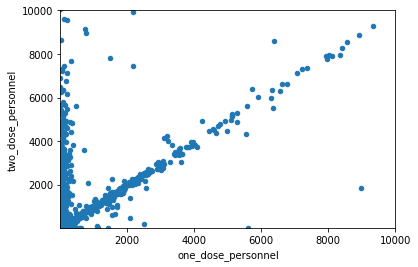

In [23]:
ax = obs_data[obs_data['collection_week'] == '2022-01-14'].plot.scatter(
    x = 'one_dose_personnel',
    y = 'two_dose_personnel'
)

ax.set_xlim(10, 10000)
ax.set_ylim(10, 10000)

In [24]:
# Is the coding error consistent across hospitals?
obs_data['correct_coding'] = np.where(obs_data['one_dose_personnel'] > obs_data['two_dose_personnel'], 1, 0)

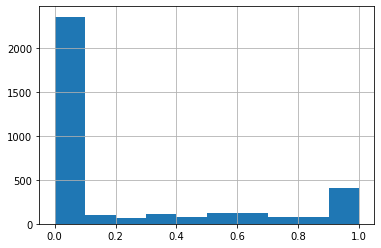

In [25]:
# Note that it is mostly consistent whether hospitals always have
# correct coding or not 
obs_data.groupby('hospital_pk')['correct_coding'].mean().hist()

## Computing data quality metrics

Data quality issues to consider:
- Indicator for whether vaccination rates are reported
    - I mean, if it's not reported, it's not exactly good data, no?
- Non-positive number of workers
    - If a hospital has no workers, either something is up
    with the reporting, or there's something REALLY 
    interesting going on.
- Substantial changes in workers over time
    - Sometimes the number of individuals in a particular group
    within the same hospital changes substantially (e.g by
    multiple orders of magnitude) over a short time period.
- More fully vaccinated workers than "one shot or more" workers
    - This is probably due to ambiguity in how the variable
    is coded (the description is contradictory in its
    intent, and what is meant to be captured by it).
- Looking at standard deviations of not vaccinated percentages
in a hospital away from the population percentages in a county
    - If this is slightly negative, or **substantially** positive,
    then this could be evidence that there is something amiss here,
    as we would expect healthcare workers to be, if anything,
    more likely to be vaccinated than the population they are in.
    Significantly positive deviations would suggest a possible
    overestimation in counts, whereas slightly negative or
    significantly negative deviations could suggest underreporting.

Workflow for computing metrics/summary statistics:
- Is the data actually reported? (Indicated by `data_reported`)
    - Are there vaccination rates reported? If not, stop here.
    - Does the hosital report all zeros for these values? If so,
    then flag `data_reported` as zero (which is different from
    the `NA` coding given if they are actually missing). 
- Is the data coded correctly? (Indicated by `correct_coding`)
    - Note that the `one_dose_personnel` should be higher
    than the `two_dose_personnel`, as the `one_dose_personnel`
    variable corresponds to the number of workers with one
    dose or more.
    - If `one_dose_personnel < two_dose_personnel`, set `correct_coding = 0`,
    otherwise set `correct_coding = 0`
- Computing some summary statistics:
    - `total_personnel = no_dose_personnel + max(one_dose_personnel,two_dose_personnel)`
    - `percentage_unvacc = no_dose_personnel/total_personnel`
    - Note that for entries with `correct_coding = 0`, the estimate
    for the number of `total_personnel` may be (wildly) incorrect; the
    max is a hack to try and account for possible discrepancies in the reporting.
- Comparing the unvaccinated rate in a hospital re: the
proportion of the state in general
    - Note that we have CDC estimates, on a county level,
    of those not vaccinated. We can compute the difference
    between the hospital level and this, with respect to
    the 'standard error' of the proportion within the
    hospital (assuming they are a representative sample
    of the population); the idea is that if these values are
    large, then this may be a sign of something wrong (as
    according to the reasoning above).    
    - This is kept in a variable called `std_error_away_from_county_pop`    

In [63]:
survey_results_df = gpd.read_file('/content/survey_results.geojson')
county_covid_df = gpd.read_file('/content/county_covid.geojson')

# Replacing suppressed values with 0 for purposes of calculation
survey_results_df = survey_results_df.replace(-999999, 0)

# Adding some data quality metrics, number of people in the hospital
survey_results_df['data_reported'] = np.where(
    survey_results_df['no_dose_personnel'] + survey_results_df['one_dose_personnel'] + survey_results_df['two_dose_personnel'] > 0,
    1, 0
)

survey_results_df['correct_coding'] = np.where(
    (survey_results_df['data_reported'] == 1) & (survey_results_df['one_dose_personnel'] >= survey_results_df['two_dose_personnel']),
    1, 0 
)

survey_results_df['total_personnel'] = survey_results_df['no_dose_personnel'] + np.maximum(survey_results_df['one_dose_personnel'], survey_results_df['two_dose_personnel'])
survey_results_df['percentage_unvacc'] = survey_results_df['no_dose_personnel'] / survey_results_df['total_personnel']
survey_results_df['std_error'] = np.sqrt(survey_results_df['percentage_unvacc']*(1-survey_results_df['percentage_unvacc'])/survey_results_df['total_personnel'])

In [64]:
survey_results_df.head()

,hospital_pk,hospital_name,collection_week,state,fips_code,no_dose_personnel,one_dose_personnel,two_dose_personnel,geometry,data_reported,correct_coding,total_personnel,percentage_unvacc,std_error
0,370220,ONECORE HEALTH,2021-04-02,OK,40109,56.0,5.0,33.0,None,1,0,89.0,0.629213,0.051200
1,201301,CHARLES A DEAN MEMORIAL HOSPITAL,2021-04-02,ME,23021,0.0,0.0,0.0,None,0,0,0.0,NaN,NaN
2,450351,TEXAS HEALTH HARRIS METHODIST HOSPITAL STEPHEN...,2021-04-02,TX,48143,NaN,NaN,NaN,POINT (-98.20485 32.22313),0,0,NaN,NaN,NaN
3,102017,SELECT SPECIALTY HOSPITAL - PANAMA CITY,2021-04-02,FL,12005,0.0,0.0,0.0,POINT (-85.64707 30.15966),0,0,0.0,NaN,NaN
4,361328,DEFIANCE REGIONAL MEDICAL CENTER,2021-04-02,OH,39039,269.0,28.0,324.0,POINT (-84.37366 41.29951),1,0,593.0,0.453626,0.020444


In [65]:
survey_county_summary = survey_results_df.groupby(['fips_code', 'collection_week']).agg({
    'no_dose_personnel': 'sum',
    'total_personnel': 'sum',
}).reset_index()

survey_county_summary['percentage_unvacc_hosp_county'] = survey_county_summary['no_dose_personnel']/survey_county_summary['total_personnel']
survey_county_summary.head()

,fips_code,collection_week,no_dose_personnel,total_personnel,percentage_unvacc_hosp_county
0,01001,2021-04-02,214.0,390.0,0.548718
1,01001,2021-04-09,212.0,390.0,0.543590
2,01001,2021-04-16,212.0,390.0,0.543590
3,01001,2021-04-23,211.0,389.0,0.542416
4,01001,2021-04-30,215.0,392.0,0.548469


In [66]:
county_covid_df['percentage_unvacc_county'] = 1 - county_covid_df['one_dose_pop']/100
county_covid_df.head()

,GEOID,date,fips,recip_county,recip_state,one_dose_pop,two_dose_pop,county_pop_size,geometry,percentage_unvacc_county
0,51740,2021-04-09,51740,Portsmouth city,VA,59.0,36.8,94398.0,"POLYGON ((-76.41935 36.86754, -76.41343 36.874...",0.410
1,29227,2021-04-09,29227,Worth County,MO,35.3,29.0,2013.0,"POLYGON ((-94.63203 40.57119, -94.59400 40.570...",0.647
2,38079,2021-04-09,38079,Rolette County,ND,62.5,58.4,14176.0,"POLYGON ((-100.18297 48.76240, -100.18297 48.7...",0.375
3,13273,2021-04-09,13273,Terrell County,GA,8.5,5.5,8531.0,"POLYGON ((-84.60282 31.78070, -84.60286 31.783...",0.915
4,56037,2021-04-09,56037,Sweetwater County,WY,34.0,26.5,42343.0,"POLYGON ((-110.05438 42.01103, -110.05436 42.0...",0.660


In [67]:
county_covid_df2 = county_covid_df.merge(
    survey_county_summary,
    left_on = ['GEOID', 'date'],
    right_on = ['fips_code', 'collection_week'],
    how = 'inner'
)

county_covid_df2.head()

,GEOID,date,fips,recip_county,recip_state,one_dose_pop,two_dose_pop,county_pop_size,geometry,percentage_unvacc_county,fips_code,collection_week,no_dose_personnel,total_personnel,percentage_unvacc_hosp_county
0,51740,2021-04-09,51740,Portsmouth city,VA,59.0,36.8,94398.0,"POLYGON ((-76.41935 36.86754, -76.41343 36.874...",0.410,51740,2021-04-09,554.0,1526.0,0.363041
1,38079,2021-04-09,38079,Rolette County,ND,62.5,58.4,14176.0,"POLYGON ((-100.18297 48.76240, -100.18297 48.7...",0.375,38079,2021-04-09,25.0,126.0,0.198413
2,56037,2021-04-09,56037,Sweetwater County,WY,34.0,26.5,42343.0,"POLYGON ((-110.05438 42.01103, -110.05436 42.0...",0.660,56037,2021-04-09,258.0,553.0,0.466546
3,01061,2021-04-09,01061,Geneva County,AL,26.6,18.2,26271.0,"POLYGON ((-86.19348 31.19221, -86.14167 31.192...",0.734,01061,2021-04-09,0.0,0.0,NaN
4,46039,2021-04-09,46039,Deuel County,SD,0.0,20.3,4351.0,"POLYGON ((-96.88518 44.63061, -96.88497 44.634...",1.000,46039,2021-04-09,0.0,0.0,NaN


In [68]:
county_covid_df2.to_file('/content/county_covid2.geojson', driver = 'GeoJSON')

In [77]:
survey_results_df2 = survey_results_df[survey_results_df['collection_week'].isin(['2021-04-09', '2021-11-05', '2021-01-14'])].reset_index()

In [78]:
survey_results_df2 = survey_results_df2.merge(
    county_covid_df2[['GEOID', 'date', 'percentage_unvacc_county']], 
    right_on = ['GEOID', 'date'],
    left_on = ['fips_code', 'collection_week'],
    how = 'left'
).assign(
    std_error_away_from_count_pop = lambda x: (x.percentage_unvacc - x.percentage_unvacc_county)/x.std_error
)

survey_results_df2.head()

,index,hospital_pk,hospital_name,collection_week,state,fips_code,no_dose_personnel,one_dose_personnel,two_dose_personnel,geometry,data_reported,correct_coding,total_personnel,percentage_unvacc,std_error,GEOID,date,percentage_unvacc_county,std_error_away_from_count_pop
0,5016,270087,THE HEALTHCENTER,2021-04-09,MT,30029,0.0,0.0,0.0,POINT (-114.32405 48.21621),0,0,0.0,NaN,NaN,30029,2021-04-09,0.721,NaN
1,5017,433300,LIFESCAPE,2021-04-09,SD,46099,0.0,20.0,20.0,POINT (-96.75559 43.52945),1,1,20.0,0.000000,0.000000,46099,2021-04-09,1.000,-inf
2,5018,050441,STANFORD HEALTH CARE,2021-04-09,CA,06085,8350.0,112.0,36.0,POINT (-122.17666 37.43314),1,1,8462.0,0.986764,0.001242,06085,2021-04-09,0.531,366.857702
3,5019,391316,UPMC WELLSBORO,2021-04-09,PA,42117,74.0,0.0,416.0,POINT (-77.29964 41.74566),1,0,490.0,0.151020,0.016176,42117,2021-04-09,0.774,-38.512828
4,5020,451313,FISHER COUNTY HOSPITAL DISTRICT,2021-04-09,TX,48151,NaN,NaN,NaN,POINT (-100.43519 32.83418),0,0,NaN,NaN,NaN,48151,2021-04-09,1.000,NaN


In [79]:
survey_results_df2.to_file('/content/survey_results2.geojson', driver = 'GeoJSON')